In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
from faster_rcnn.utils.cython_bbox import bbox_overlaps
from pycrayon import CrayonClient

import cPickle
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from faster_rcnn.utils.datasets.adapter import convert_data
from faster_rcnn.utils.evaluate.metter import AverageMeter
from faster_rcnn.utils.display.images import imshow, result_show

In [3]:
with open('sorted_index', 'rb') as fp:
    sorted_index = cPickle.load(fp)

### Đọc dữ liệu từ MS COCO dataset


In [4]:
from faster_rcnn.utils.datasets.adapter import convert_data

In [5]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.datasets.mscoco.dataset import CocoData
from torch.utils.data import DataLoader



dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
batch_size = 8

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir, annFile = annFile,sorted_indexes=sorted_index)

train_data_loader = DataLoader(cap, batch_size=batch_size, shuffle=False, collate_fn=convert_data, num_workers=0, drop_last=True)

loading annotations into memory...
Done (t=10.04s)
creating index...
index created!


In [6]:
train_data_loader.batch_size
print len(train_data_loader)

10347


Thử hiển thị ảnh cùng các bounding boxes

In [7]:
from faster_rcnn.faster_rcnn import FastRCNN


### Tính toán feed-forward


Chúng ta sử dụng một ảnh có kích thước đầu vào là  `(width , height) = (600, 800)`

Input:
    - im_data : 
        kích thước : (batch_size, dim, witdh, height)
    - ground_boxes: 
        kích thước (n, 4)
        

In [8]:
categories = ['__background__'] + [x['name'] for x in cap.coco.loadCats(cap.coco.getCatIds())]

In [9]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

/opt/conda/envs/pytorch/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [11]:
param = filter(lambda x: x.requires_grad, net.parameters())
optimizer = SGD(param, lr=1e-3, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)

In [12]:
def train(data_gen ,model, tensorboard_client, metters, optimizer, lr_scheduler, current_epoch=0):
    
    steps_per_epoch = len(data_gen) 
    model.train()
    train_loss , cross_entropy , loss_box, rpn_loss = metters
    for step, blobs in enumerate(data_gen):
        batch_tensor, im_info, batch_boxes, batch_boxes_index = blobs
        cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
        rpn_cross_entropy, rpn_bbox_loss = model.rpn.build_loss(rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target)
        cross_entropy, bbox_loss = model.build_loss(cls_score, bbox_pred, target)
        loss = rpn_cross_entropy + rpn_bbox_loss * 10 + cross_entropy + bbox_loss * 10
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        train_loss.update(loss.item())     

        current_step = current_epoch * steps_per_epoch + step
        if step % 10 == 1:
            log_text = 'epoch: %d : step %d,  loss: %.4f at %s' % (
                current_epoch + 1, step , train_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
            print(log_text)

        if step % 100 == 0:
            tensorboard_client.add_scalar_value('train_loss', train_loss.avg, step=current_step)
        
        del loss, rpn_cross_entropy , rpn_bbox_loss , cross_entropy , bbox_loss, cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target


In [13]:
def training(train_data_gen, optimizer, lr_scheduler ,model, epochs=10):
    
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%Ms')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    
    
    train_loss = AverageMeter()
    cross_entropy = AverageMeter()
    loss_box = AverageMeter()
    rpn_loss = AverageMeter()
    metters = (train_loss , cross_entropy , loss_box, rpn_loss)

    for epoch in range(epochs):
        train(train_data_gen ,model, exp, metters, optimizer, lr_scheduler, epoch)
        torch.save(net.state_dict(), './checkpoints/faster_model_at_%d.pkl' % epoch) 

In [14]:
training(train_data_loader ,optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=5)

faster_rcnn/rpn_msr/anchor_target_layer.py:333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  current_batch_boxes = batch_boxes[[batch_boxes_index == i]]
faster_rcnn/rpn_msr/proposal_target_layer.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  current_gt_boxes = gt_boxes[[gt_boxes_index == i]]
faster_rcnn/faster_rcnn.py:262: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


epoch: 1 : step 1,  loss: 14.0707 at 09/29_15:48


No handlers could be found for logger "faster_rcnn.utils.datasets.mscoco.dataset"


epoch: 1 : step 11,  loss: 7.5500 at 09/29_15:49
epoch: 1 : step 21,  loss: 6.1019 at 09/29_15:49
epoch: 1 : step 31,  loss: 5.5548 at 09/29_15:49
epoch: 1 : step 41,  loss: 5.3321 at 09/29_15:50
epoch: 1 : step 51,  loss: 5.0803 at 09/29_15:50
epoch: 1 : step 61,  loss: 4.8542 at 09/29_15:50
epoch: 1 : step 71,  loss: 4.7215 at 09/29_15:50
epoch: 1 : step 81,  loss: 4.6180 at 09/29_15:51
epoch: 1 : step 91,  loss: 4.4790 at 09/29_15:51
epoch: 1 : step 101,  loss: 4.3730 at 09/29_15:51
epoch: 1 : step 111,  loss: 4.2995 at 09/29_15:52
epoch: 1 : step 121,  loss: 4.2253 at 09/29_15:52
epoch: 1 : step 131,  loss: 4.1494 at 09/29_15:52
epoch: 1 : step 141,  loss: 4.0869 at 09/29_15:52
epoch: 1 : step 151,  loss: 4.0391 at 09/29_15:53
epoch: 1 : step 161,  loss: 4.0062 at 09/29_15:53
epoch: 1 : step 171,  loss: 3.9752 at 09/29_15:53
epoch: 1 : step 181,  loss: 3.9410 at 09/29_15:54
epoch: 1 : step 191,  loss: 3.9179 at 09/29_15:54
epoch: 1 : step 201,  loss: 3.8772 at 09/29_15:54
epoch: 1 

epoch: 1 : step 1641,  loss: 3.1147 at 09/29_16:32
epoch: 1 : step 1651,  loss: 3.1147 at 09/29_16:33
epoch: 1 : step 1661,  loss: 3.1140 at 09/29_16:33
epoch: 1 : step 1671,  loss: 3.1141 at 09/29_16:33
epoch: 1 : step 1681,  loss: 3.1134 at 09/29_16:33
epoch: 1 : step 1691,  loss: 3.1115 at 09/29_16:34
epoch: 1 : step 1701,  loss: 3.1090 at 09/29_16:34
epoch: 1 : step 1711,  loss: 3.1084 at 09/29_16:34
epoch: 1 : step 1721,  loss: 3.1075 at 09/29_16:35
epoch: 1 : step 1731,  loss: 3.1057 at 09/29_16:35
epoch: 1 : step 1741,  loss: 3.1053 at 09/29_16:35
epoch: 1 : step 1751,  loss: 3.1043 at 09/29_16:35
epoch: 1 : step 1761,  loss: 3.1044 at 09/29_16:36
epoch: 1 : step 1771,  loss: 3.1032 at 09/29_16:36
epoch: 1 : step 1781,  loss: 3.1020 at 09/29_16:36
epoch: 1 : step 1791,  loss: 3.1007 at 09/29_16:36
epoch: 1 : step 1801,  loss: 3.0995 at 09/29_16:37
epoch: 1 : step 1811,  loss: 3.0982 at 09/29_16:37
epoch: 1 : step 1821,  loss: 3.0967 at 09/29_16:37
epoch: 1 : step 1831,  loss: 3.

epoch: 1 : step 3251,  loss: 2.9485 at 09/29_17:14
epoch: 1 : step 3261,  loss: 2.9472 at 09/29_17:14
epoch: 1 : step 3271,  loss: 2.9458 at 09/29_17:14
epoch: 1 : step 3281,  loss: 2.9449 at 09/29_17:15
epoch: 1 : step 3291,  loss: 2.9442 at 09/29_17:15
epoch: 1 : step 3301,  loss: 2.9434 at 09/29_17:15
epoch: 1 : step 3311,  loss: 2.9428 at 09/29_17:15
epoch: 1 : step 3321,  loss: 2.9427 at 09/29_17:16
epoch: 1 : step 3331,  loss: 2.9418 at 09/29_17:16
epoch: 1 : step 3341,  loss: 2.9413 at 09/29_17:16
epoch: 1 : step 3351,  loss: 2.9406 at 09/29_17:16
epoch: 1 : step 3361,  loss: 2.9402 at 09/29_17:17
epoch: 1 : step 3371,  loss: 2.9400 at 09/29_17:17
epoch: 1 : step 3381,  loss: 2.9397 at 09/29_17:17
epoch: 1 : step 3391,  loss: 2.9389 at 09/29_17:18
epoch: 1 : step 3401,  loss: 2.9388 at 09/29_17:18
epoch: 1 : step 3411,  loss: 2.9384 at 09/29_17:18
epoch: 1 : step 3421,  loss: 2.9383 at 09/29_17:18
epoch: 1 : step 3431,  loss: 2.9381 at 09/29_17:19
epoch: 1 : step 3441,  loss: 2.

epoch: 1 : step 4861,  loss: 2.8630 at 09/29_17:57
epoch: 1 : step 4871,  loss: 2.8624 at 09/29_17:57
epoch: 1 : step 4881,  loss: 2.8615 at 09/29_17:57
epoch: 1 : step 4891,  loss: 2.8611 at 09/29_17:58
epoch: 1 : step 4901,  loss: 2.8608 at 09/29_17:58
epoch: 1 : step 4911,  loss: 2.8604 at 09/29_17:58
epoch: 1 : step 4921,  loss: 2.8600 at 09/29_17:59
epoch: 1 : step 4931,  loss: 2.8594 at 09/29_17:59
epoch: 1 : step 4941,  loss: 2.8589 at 09/29_17:59
epoch: 1 : step 4951,  loss: 2.8585 at 09/29_17:59
epoch: 1 : step 4961,  loss: 2.8580 at 09/29_18:00
epoch: 1 : step 4971,  loss: 2.8574 at 09/29_18:00
epoch: 1 : step 4981,  loss: 2.8569 at 09/29_18:00
epoch: 1 : step 4991,  loss: 2.8565 at 09/29_18:00
epoch: 1 : step 5001,  loss: 2.8560 at 09/29_18:01
epoch: 1 : step 5011,  loss: 2.8555 at 09/29_18:01
epoch: 1 : step 5021,  loss: 2.8551 at 09/29_18:01
epoch: 1 : step 5031,  loss: 2.8546 at 09/29_18:01
epoch: 1 : step 5041,  loss: 2.8540 at 09/29_18:02
epoch: 1 : step 5051,  loss: 2.

epoch: 1 : step 6471,  loss: 2.7775 at 09/29_18:40
epoch: 1 : step 6481,  loss: 2.7771 at 09/29_18:41
epoch: 1 : step 6491,  loss: 2.7764 at 09/29_18:41
epoch: 1 : step 6501,  loss: 2.7756 at 09/29_18:41
epoch: 1 : step 6511,  loss: 2.7752 at 09/29_18:41
epoch: 1 : step 6521,  loss: 2.7746 at 09/29_18:42
epoch: 1 : step 6531,  loss: 2.7741 at 09/29_18:42
epoch: 1 : step 6541,  loss: 2.7734 at 09/29_18:42
epoch: 1 : step 6551,  loss: 2.7729 at 09/29_18:43
epoch: 1 : step 6561,  loss: 2.7721 at 09/29_18:43
epoch: 1 : step 6571,  loss: 2.7713 at 09/29_18:43
epoch: 1 : step 6581,  loss: 2.7708 at 09/29_18:43
epoch: 1 : step 6591,  loss: 2.7702 at 09/29_18:44
epoch: 1 : step 6601,  loss: 2.7697 at 09/29_18:44
epoch: 1 : step 6611,  loss: 2.7690 at 09/29_18:44
epoch: 1 : step 6621,  loss: 2.7683 at 09/29_18:44
epoch: 1 : step 6631,  loss: 2.7677 at 09/29_18:45
epoch: 1 : step 6641,  loss: 2.7671 at 09/29_18:45
epoch: 1 : step 6651,  loss: 2.7664 at 09/29_18:45
epoch: 1 : step 6661,  loss: 2.

epoch: 1 : step 8081,  loss: 2.6936 at 09/29_19:25
epoch: 1 : step 8091,  loss: 2.6933 at 09/29_19:26
epoch: 1 : step 8101,  loss: 2.6928 at 09/29_19:26
epoch: 1 : step 8111,  loss: 2.6925 at 09/29_19:26
epoch: 1 : step 8121,  loss: 2.6921 at 09/29_19:27
epoch: 1 : step 8131,  loss: 2.6918 at 09/29_19:27
epoch: 1 : step 8141,  loss: 2.6913 at 09/29_19:27
epoch: 1 : step 8151,  loss: 2.6908 at 09/29_19:27
epoch: 1 : step 8161,  loss: 2.6903 at 09/29_19:28
epoch: 1 : step 8171,  loss: 2.6899 at 09/29_19:28
epoch: 1 : step 8181,  loss: 2.6893 at 09/29_19:28
epoch: 1 : step 8191,  loss: 2.6888 at 09/29_19:29
epoch: 1 : step 8201,  loss: 2.6883 at 09/29_19:29
epoch: 1 : step 8211,  loss: 2.6880 at 09/29_19:29
epoch: 1 : step 8221,  loss: 2.6876 at 09/29_19:29
epoch: 1 : step 8231,  loss: 2.6871 at 09/29_19:30
epoch: 1 : step 8241,  loss: 2.6866 at 09/29_19:30
epoch: 1 : step 8251,  loss: 2.6861 at 09/29_19:30
epoch: 1 : step 8261,  loss: 2.6855 at 09/29_19:30
epoch: 1 : step 8271,  loss: 2.

epoch: 1 : step 9691,  loss: 2.6292 at 09/29_20:10
epoch: 1 : step 9701,  loss: 2.6289 at 09/29_20:11
epoch: 1 : step 9711,  loss: 2.6284 at 09/29_20:11
epoch: 1 : step 9721,  loss: 2.6278 at 09/29_20:11
epoch: 1 : step 9731,  loss: 2.6273 at 09/29_20:12
epoch: 1 : step 9741,  loss: 2.6268 at 09/29_20:12
epoch: 1 : step 9751,  loss: 2.6267 at 09/29_20:12
epoch: 1 : step 9761,  loss: 2.6263 at 09/29_20:12
epoch: 1 : step 9771,  loss: 2.6257 at 09/29_20:13
epoch: 1 : step 9781,  loss: 2.6253 at 09/29_20:13
epoch: 1 : step 9791,  loss: 2.6250 at 09/29_20:13
epoch: 1 : step 9801,  loss: 2.6248 at 09/29_20:14
epoch: 1 : step 9811,  loss: 2.6243 at 09/29_20:14
epoch: 1 : step 9821,  loss: 2.6239 at 09/29_20:14
epoch: 1 : step 9831,  loss: 2.6235 at 09/29_20:14
epoch: 1 : step 9841,  loss: 2.6232 at 09/29_20:15
epoch: 1 : step 9851,  loss: 2.6228 at 09/29_20:15
epoch: 1 : step 9861,  loss: 2.6225 at 09/29_20:15
epoch: 1 : step 9871,  loss: 2.6225 at 09/29_20:16
epoch: 1 : step 9881,  loss: 2.

epoch: 2 : step 971,  loss: 2.5815 at 09/29_20:58
epoch: 2 : step 981,  loss: 2.5812 at 09/29_20:58
epoch: 2 : step 991,  loss: 2.5807 at 09/29_20:58
epoch: 2 : step 1001,  loss: 2.5803 at 09/29_20:59
epoch: 2 : step 1011,  loss: 2.5800 at 09/29_20:59
epoch: 2 : step 1021,  loss: 2.5796 at 09/29_20:59
epoch: 2 : step 1031,  loss: 2.5793 at 09/29_20:59
epoch: 2 : step 1041,  loss: 2.5790 at 09/29_21:00
epoch: 2 : step 1051,  loss: 2.5784 at 09/29_21:00
epoch: 2 : step 1061,  loss: 2.5783 at 09/29_21:00
epoch: 2 : step 1071,  loss: 2.5779 at 09/29_21:00
epoch: 2 : step 1081,  loss: 2.5775 at 09/29_21:01
epoch: 2 : step 1091,  loss: 2.5771 at 09/29_21:01
epoch: 2 : step 1101,  loss: 2.5766 at 09/29_21:01
epoch: 2 : step 1111,  loss: 2.5761 at 09/29_21:02
epoch: 2 : step 1121,  loss: 2.5756 at 09/29_21:02
epoch: 2 : step 1131,  loss: 2.5752 at 09/29_21:02
epoch: 2 : step 1141,  loss: 2.5747 at 09/29_21:02
epoch: 2 : step 1151,  loss: 2.5743 at 09/29_21:03
epoch: 2 : step 1161,  loss: 2.573

epoch: 2 : step 2581,  loss: 2.5295 at 09/29_21:40
epoch: 2 : step 2591,  loss: 2.5292 at 09/29_21:40
epoch: 2 : step 2601,  loss: 2.5289 at 09/29_21:41
epoch: 2 : step 2611,  loss: 2.5286 at 09/29_21:41
epoch: 2 : step 2621,  loss: 2.5283 at 09/29_21:41
epoch: 2 : step 2631,  loss: 2.5280 at 09/29_21:41
epoch: 2 : step 2641,  loss: 2.5278 at 09/29_21:42
epoch: 2 : step 2651,  loss: 2.5275 at 09/29_21:42
epoch: 2 : step 2661,  loss: 2.5273 at 09/29_21:42
epoch: 2 : step 2671,  loss: 2.5271 at 09/29_21:42
epoch: 2 : step 2681,  loss: 2.5268 at 09/29_21:42
epoch: 2 : step 2691,  loss: 2.5266 at 09/29_21:43
epoch: 2 : step 2701,  loss: 2.5264 at 09/29_21:43
epoch: 2 : step 2711,  loss: 2.5261 at 09/29_21:43
epoch: 2 : step 2721,  loss: 2.5258 at 09/29_21:43
epoch: 2 : step 2731,  loss: 2.5255 at 09/29_21:44
epoch: 2 : step 2741,  loss: 2.5253 at 09/29_21:44
epoch: 2 : step 2751,  loss: 2.5251 at 09/29_21:44
epoch: 2 : step 2761,  loss: 2.5249 at 09/29_21:44
epoch: 2 : step 2771,  loss: 2.

epoch: 2 : step 4191,  loss: 2.4901 at 09/29_22:22
epoch: 2 : step 4201,  loss: 2.4900 at 09/29_22:22
epoch: 2 : step 4211,  loss: 2.4899 at 09/29_22:23
epoch: 2 : step 4221,  loss: 2.4896 at 09/29_22:23
epoch: 2 : step 4231,  loss: 2.4895 at 09/29_22:23
epoch: 2 : step 4241,  loss: 2.4894 at 09/29_22:23
epoch: 2 : step 4251,  loss: 2.4891 at 09/29_22:24
epoch: 2 : step 4261,  loss: 2.4890 at 09/29_22:24
epoch: 2 : step 4271,  loss: 2.4888 at 09/29_22:24
epoch: 2 : step 4281,  loss: 2.4886 at 09/29_22:24
epoch: 2 : step 4291,  loss: 2.4884 at 09/29_22:25
epoch: 2 : step 4301,  loss: 2.4882 at 09/29_22:25
epoch: 2 : step 4311,  loss: 2.4881 at 09/29_22:25
epoch: 2 : step 4321,  loss: 2.4879 at 09/29_22:26
epoch: 2 : step 4331,  loss: 2.4877 at 09/29_22:26
epoch: 2 : step 4341,  loss: 2.4874 at 09/29_22:26
epoch: 2 : step 4351,  loss: 2.4871 at 09/29_22:26
epoch: 2 : step 4361,  loss: 2.4870 at 09/29_22:27
epoch: 2 : step 4371,  loss: 2.4868 at 09/29_22:27
epoch: 2 : step 4381,  loss: 2.

epoch: 2 : step 5801,  loss: 2.4601 at 09/29_23:05
epoch: 2 : step 5811,  loss: 2.4599 at 09/29_23:05
epoch: 2 : step 5821,  loss: 2.4597 at 09/29_23:06
epoch: 2 : step 5831,  loss: 2.4595 at 09/29_23:06
epoch: 2 : step 5841,  loss: 2.4594 at 09/29_23:06
epoch: 2 : step 5851,  loss: 2.4592 at 09/29_23:07
epoch: 2 : step 5861,  loss: 2.4590 at 09/29_23:07
epoch: 2 : step 5871,  loss: 2.4588 at 09/29_23:07
epoch: 2 : step 5881,  loss: 2.4586 at 09/29_23:07
epoch: 2 : step 5891,  loss: 2.4584 at 09/29_23:08
epoch: 2 : step 5901,  loss: 2.4582 at 09/29_23:08
epoch: 2 : step 5911,  loss: 2.4580 at 09/29_23:08
epoch: 2 : step 5921,  loss: 2.4578 at 09/29_23:08
epoch: 2 : step 5931,  loss: 2.4576 at 09/29_23:09
epoch: 2 : step 5941,  loss: 2.4575 at 09/29_23:09
epoch: 2 : step 5951,  loss: 2.4574 at 09/29_23:09
epoch: 2 : step 5961,  loss: 2.4571 at 09/29_23:09
epoch: 2 : step 5971,  loss: 2.4569 at 09/29_23:10
epoch: 2 : step 5981,  loss: 2.4567 at 09/29_23:10
epoch: 2 : step 5991,  loss: 2.

epoch: 2 : step 7411,  loss: 2.4269 at 09/29_23:49
epoch: 2 : step 7421,  loss: 2.4267 at 09/29_23:50
epoch: 2 : step 7431,  loss: 2.4265 at 09/29_23:50
epoch: 2 : step 7441,  loss: 2.4263 at 09/29_23:50
epoch: 2 : step 7451,  loss: 2.4260 at 09/29_23:51
epoch: 2 : step 7461,  loss: 2.4258 at 09/29_23:51
epoch: 2 : step 7471,  loss: 2.4256 at 09/29_23:51
epoch: 2 : step 7481,  loss: 2.4254 at 09/29_23:51
epoch: 2 : step 7491,  loss: 2.4251 at 09/29_23:52
epoch: 2 : step 7501,  loss: 2.4248 at 09/29_23:52
epoch: 2 : step 7511,  loss: 2.4246 at 09/29_23:52
epoch: 2 : step 7521,  loss: 2.4243 at 09/29_23:52
epoch: 2 : step 7531,  loss: 2.4241 at 09/29_23:53
epoch: 2 : step 7541,  loss: 2.4240 at 09/29_23:53
epoch: 2 : step 7551,  loss: 2.4238 at 09/29_23:53
epoch: 2 : step 7561,  loss: 2.4235 at 09/29_23:54
epoch: 2 : step 7571,  loss: 2.4232 at 09/29_23:54
epoch: 2 : step 7581,  loss: 2.4230 at 09/29_23:54
epoch: 2 : step 7591,  loss: 2.4230 at 09/29_23:54
epoch: 2 : step 7601,  loss: 2.

epoch: 2 : step 9021,  loss: 2.3948 at 09/30_00:34
epoch: 2 : step 9031,  loss: 2.3945 at 09/30_00:34
epoch: 2 : step 9041,  loss: 2.3943 at 09/30_00:34
epoch: 2 : step 9051,  loss: 2.3941 at 09/30_00:35
epoch: 2 : step 9061,  loss: 2.3940 at 09/30_00:35
epoch: 2 : step 9071,  loss: 2.3938 at 09/30_00:35
epoch: 2 : step 9081,  loss: 2.3936 at 09/30_00:35
epoch: 2 : step 9091,  loss: 2.3935 at 09/30_00:36
epoch: 2 : step 9101,  loss: 2.3933 at 09/30_00:36
epoch: 2 : step 9111,  loss: 2.3932 at 09/30_00:36
epoch: 2 : step 9121,  loss: 2.3930 at 09/30_00:37
epoch: 2 : step 9131,  loss: 2.3928 at 09/30_00:37
epoch: 2 : step 9141,  loss: 2.3927 at 09/30_00:37
epoch: 2 : step 9151,  loss: 2.3926 at 09/30_00:37
epoch: 2 : step 9161,  loss: 2.3924 at 09/30_00:38
epoch: 2 : step 9171,  loss: 2.3923 at 09/30_00:38
epoch: 2 : step 9181,  loss: 2.3921 at 09/30_00:38
epoch: 2 : step 9191,  loss: 2.3919 at 09/30_00:39
epoch: 2 : step 9201,  loss: 2.3917 at 09/30_00:39
epoch: 2 : step 9211,  loss: 2.

epoch: 3 : step 281,  loss: 2.3737 at 09/30_01:21
epoch: 3 : step 291,  loss: 2.3736 at 09/30_01:21
epoch: 3 : step 301,  loss: 2.3734 at 09/30_01:21
epoch: 3 : step 311,  loss: 2.3731 at 09/30_01:21
epoch: 3 : step 321,  loss: 2.3730 at 09/30_01:22
epoch: 3 : step 331,  loss: 2.3727 at 09/30_01:22
epoch: 3 : step 341,  loss: 2.3726 at 09/30_01:22
epoch: 3 : step 351,  loss: 2.3724 at 09/30_01:22
epoch: 3 : step 361,  loss: 2.3722 at 09/30_01:23
epoch: 3 : step 371,  loss: 2.3720 at 09/30_01:23
epoch: 3 : step 381,  loss: 2.3717 at 09/30_01:23
epoch: 3 : step 391,  loss: 2.3715 at 09/30_01:24
epoch: 3 : step 401,  loss: 2.3713 at 09/30_01:24
epoch: 3 : step 411,  loss: 2.3710 at 09/30_01:24
epoch: 3 : step 421,  loss: 2.3709 at 09/30_01:24
epoch: 3 : step 431,  loss: 2.3708 at 09/30_01:25
epoch: 3 : step 441,  loss: 2.3705 at 09/30_01:25
epoch: 3 : step 451,  loss: 2.3703 at 09/30_01:25
epoch: 3 : step 461,  loss: 2.3701 at 09/30_01:26
epoch: 3 : step 471,  loss: 2.3700 at 09/30_01:26


epoch: 3 : step 1911,  loss: 2.3462 at 09/30_02:05
epoch: 3 : step 1921,  loss: 2.3460 at 09/30_02:05
epoch: 3 : step 1931,  loss: 2.3459 at 09/30_02:05
epoch: 3 : step 1941,  loss: 2.3457 at 09/30_02:05
epoch: 3 : step 1951,  loss: 2.3456 at 09/30_02:06
epoch: 3 : step 1961,  loss: 2.3454 at 09/30_02:06
epoch: 3 : step 1971,  loss: 2.3453 at 09/30_02:06
epoch: 3 : step 1981,  loss: 2.3451 at 09/30_02:06
epoch: 3 : step 1991,  loss: 2.3450 at 09/30_02:07
epoch: 3 : step 2001,  loss: 2.3448 at 09/30_02:07
epoch: 3 : step 2011,  loss: 2.3446 at 09/30_02:07
epoch: 3 : step 2021,  loss: 2.3445 at 09/30_02:08
epoch: 3 : step 2031,  loss: 2.3443 at 09/30_02:08
epoch: 3 : step 2041,  loss: 2.3442 at 09/30_02:08
epoch: 3 : step 2051,  loss: 2.3440 at 09/30_02:08
epoch: 3 : step 2061,  loss: 2.3439 at 09/30_02:09
epoch: 3 : step 2071,  loss: 2.3437 at 09/30_02:09
epoch: 3 : step 2081,  loss: 2.3435 at 09/30_02:09
epoch: 3 : step 2091,  loss: 2.3433 at 09/30_02:09
epoch: 3 : step 2101,  loss: 2.

epoch: 3 : step 3521,  loss: 2.3204 at 09/30_02:46
epoch: 3 : step 3531,  loss: 2.3203 at 09/30_02:46
epoch: 3 : step 3541,  loss: 2.3201 at 09/30_02:46
epoch: 3 : step 3551,  loss: 2.3199 at 09/30_02:46
epoch: 3 : step 3561,  loss: 2.3198 at 09/30_02:47
epoch: 3 : step 3571,  loss: 2.3197 at 09/30_02:47
epoch: 3 : step 3581,  loss: 2.3196 at 09/30_02:47
epoch: 3 : step 3591,  loss: 2.3195 at 09/30_02:47
epoch: 3 : step 3601,  loss: 2.3193 at 09/30_02:48
epoch: 3 : step 3611,  loss: 2.3192 at 09/30_02:48
epoch: 3 : step 3621,  loss: 2.3191 at 09/30_02:48
epoch: 3 : step 3631,  loss: 2.3189 at 09/30_02:48
epoch: 3 : step 3641,  loss: 2.3188 at 09/30_02:49
epoch: 3 : step 3651,  loss: 2.3188 at 09/30_02:49
epoch: 3 : step 3661,  loss: 2.3187 at 09/30_02:49
epoch: 3 : step 3671,  loss: 2.3185 at 09/30_02:50
epoch: 3 : step 3681,  loss: 2.3185 at 09/30_02:50
epoch: 3 : step 3691,  loss: 2.3184 at 09/30_02:50
epoch: 3 : step 3701,  loss: 2.3182 at 09/30_02:50
epoch: 3 : step 3711,  loss: 2.

epoch: 3 : step 5131,  loss: 2.3031 at 09/30_03:28
epoch: 3 : step 5141,  loss: 2.3030 at 09/30_03:29
epoch: 3 : step 5151,  loss: 2.3029 at 09/30_03:29
epoch: 3 : step 5161,  loss: 2.3027 at 09/30_03:29
epoch: 3 : step 5171,  loss: 2.3027 at 09/30_03:29
epoch: 3 : step 5181,  loss: 2.3026 at 09/30_03:30
epoch: 3 : step 5191,  loss: 2.3025 at 09/30_03:30
epoch: 3 : step 5201,  loss: 2.3025 at 09/30_03:30
epoch: 3 : step 5211,  loss: 2.3024 at 09/30_03:30
epoch: 3 : step 5221,  loss: 2.3023 at 09/30_03:31
epoch: 3 : step 5231,  loss: 2.3021 at 09/30_03:31
epoch: 3 : step 5241,  loss: 2.3020 at 09/30_03:31
epoch: 3 : step 5251,  loss: 2.3019 at 09/30_03:31
epoch: 3 : step 5261,  loss: 2.3017 at 09/30_03:32
epoch: 3 : step 5271,  loss: 2.3016 at 09/30_03:32
epoch: 3 : step 5281,  loss: 2.3015 at 09/30_03:32
epoch: 3 : step 5291,  loss: 2.3014 at 09/30_03:32
epoch: 3 : step 5301,  loss: 2.3012 at 09/30_03:33
epoch: 3 : step 5311,  loss: 2.3011 at 09/30_03:33
epoch: 3 : step 5321,  loss: 2.

epoch: 3 : step 6741,  loss: 2.2851 at 09/30_04:11
epoch: 3 : step 6751,  loss: 2.2850 at 09/30_04:12
epoch: 3 : step 6761,  loss: 2.2849 at 09/30_04:12
epoch: 3 : step 6771,  loss: 2.2848 at 09/30_04:12
epoch: 3 : step 6781,  loss: 2.2847 at 09/30_04:13
epoch: 3 : step 6791,  loss: 2.2846 at 09/30_04:13
epoch: 3 : step 6801,  loss: 2.2844 at 09/30_04:13
epoch: 3 : step 6811,  loss: 2.2843 at 09/30_04:13
epoch: 3 : step 6821,  loss: 2.2842 at 09/30_04:14
epoch: 3 : step 6831,  loss: 2.2841 at 09/30_04:14
epoch: 3 : step 6841,  loss: 2.2840 at 09/30_04:14
epoch: 3 : step 6851,  loss: 2.2838 at 09/30_04:15
epoch: 3 : step 6861,  loss: 2.2837 at 09/30_04:15
epoch: 3 : step 6871,  loss: 2.2836 at 09/30_04:15
epoch: 3 : step 6881,  loss: 2.2835 at 09/30_04:15
epoch: 3 : step 6891,  loss: 2.2834 at 09/30_04:16
epoch: 3 : step 6901,  loss: 2.2833 at 09/30_04:16
epoch: 3 : step 6911,  loss: 2.2833 at 09/30_04:16
epoch: 3 : step 6921,  loss: 2.2832 at 09/30_04:17
epoch: 3 : step 6931,  loss: 2.

epoch: 3 : step 8351,  loss: 2.2667 at 09/30_04:56
epoch: 3 : step 8361,  loss: 2.2665 at 09/30_04:56
epoch: 3 : step 8371,  loss: 2.2664 at 09/30_04:57
epoch: 3 : step 8381,  loss: 2.2663 at 09/30_04:57
epoch: 3 : step 8391,  loss: 2.2661 at 09/30_04:57
epoch: 3 : step 8401,  loss: 2.2660 at 09/30_04:57
epoch: 3 : step 8411,  loss: 2.2659 at 09/30_04:58
epoch: 3 : step 8421,  loss: 2.2658 at 09/30_04:58
epoch: 3 : step 8431,  loss: 2.2657 at 09/30_04:58
epoch: 3 : step 8441,  loss: 2.2656 at 09/30_04:58
epoch: 3 : step 8451,  loss: 2.2655 at 09/30_04:59
epoch: 3 : step 8461,  loss: 2.2654 at 09/30_04:59
epoch: 3 : step 8471,  loss: 2.2654 at 09/30_04:59
epoch: 3 : step 8481,  loss: 2.2653 at 09/30_05:00
epoch: 3 : step 8491,  loss: 2.2652 at 09/30_05:00
epoch: 3 : step 8501,  loss: 2.2651 at 09/30_05:00
epoch: 3 : step 8511,  loss: 2.2651 at 09/30_05:00
epoch: 3 : step 8521,  loss: 2.2650 at 09/30_05:01
epoch: 3 : step 8531,  loss: 2.2649 at 09/30_05:01
epoch: 3 : step 8541,  loss: 2.

epoch: 3 : step 9961,  loss: 2.2507 at 09/30_05:41
epoch: 3 : step 9971,  loss: 2.2507 at 09/30_05:41
epoch: 3 : step 9981,  loss: 2.2506 at 09/30_05:41
epoch: 3 : step 9991,  loss: 2.2506 at 09/30_05:42
epoch: 3 : step 10001,  loss: 2.2506 at 09/30_05:42
epoch: 3 : step 10011,  loss: 2.2505 at 09/30_05:42
epoch: 3 : step 10021,  loss: 2.2504 at 09/30_05:42
epoch: 3 : step 10031,  loss: 2.2504 at 09/30_05:43
epoch: 3 : step 10041,  loss: 2.2503 at 09/30_05:43
epoch: 3 : step 10051,  loss: 2.2502 at 09/30_05:43
epoch: 3 : step 10061,  loss: 2.2503 at 09/30_05:44
epoch: 3 : step 10071,  loss: 2.2502 at 09/30_05:44
epoch: 3 : step 10081,  loss: 2.2502 at 09/30_05:44
epoch: 3 : step 10091,  loss: 2.2501 at 09/30_05:45
epoch: 3 : step 10101,  loss: 2.2501 at 09/30_05:45
epoch: 3 : step 10111,  loss: 2.2500 at 09/30_05:45
epoch: 3 : step 10121,  loss: 2.2500 at 09/30_05:45
epoch: 3 : step 10131,  loss: 2.2500 at 09/30_05:46
epoch: 3 : step 10141,  loss: 2.2499 at 09/30_05:46
epoch: 3 : step 

epoch: 4 : step 1241,  loss: 2.2374 at 09/30_06:27
epoch: 4 : step 1251,  loss: 2.2373 at 09/30_06:27
epoch: 4 : step 1261,  loss: 2.2372 at 09/30_06:27
epoch: 4 : step 1271,  loss: 2.2371 at 09/30_06:28
epoch: 4 : step 1281,  loss: 2.2370 at 09/30_06:28
epoch: 4 : step 1291,  loss: 2.2369 at 09/30_06:28
epoch: 4 : step 1301,  loss: 2.2368 at 09/30_06:28
epoch: 4 : step 1311,  loss: 2.2367 at 09/30_06:29
epoch: 4 : step 1321,  loss: 2.2366 at 09/30_06:29
epoch: 4 : step 1331,  loss: 2.2365 at 09/30_06:29
epoch: 4 : step 1341,  loss: 2.2364 at 09/30_06:29
epoch: 4 : step 1351,  loss: 2.2363 at 09/30_06:30
epoch: 4 : step 1361,  loss: 2.2362 at 09/30_06:30
epoch: 4 : step 1371,  loss: 2.2361 at 09/30_06:30
epoch: 4 : step 1381,  loss: 2.2360 at 09/30_06:31
epoch: 4 : step 1391,  loss: 2.2359 at 09/30_06:31
epoch: 4 : step 1401,  loss: 2.2358 at 09/30_06:31
epoch: 4 : step 1411,  loss: 2.2357 at 09/30_06:31
epoch: 4 : step 1421,  loss: 2.2356 at 09/30_06:32
epoch: 4 : step 1431,  loss: 2.

epoch: 4 : step 2851,  loss: 2.2220 at 09/30_07:08
epoch: 4 : step 2861,  loss: 2.2218 at 09/30_07:09
epoch: 4 : step 2871,  loss: 2.2218 at 09/30_07:09
epoch: 4 : step 2881,  loss: 2.2216 at 09/30_07:09
epoch: 4 : step 2891,  loss: 2.2215 at 09/30_07:09
epoch: 4 : step 2901,  loss: 2.2214 at 09/30_07:10
epoch: 4 : step 2911,  loss: 2.2214 at 09/30_07:10
epoch: 4 : step 2921,  loss: 2.2213 at 09/30_07:10
epoch: 4 : step 2931,  loss: 2.2212 at 09/30_07:10
epoch: 4 : step 2941,  loss: 2.2211 at 09/30_07:11
epoch: 4 : step 2951,  loss: 2.2209 at 09/30_07:11
epoch: 4 : step 2961,  loss: 2.2208 at 09/30_07:11
epoch: 4 : step 2971,  loss: 2.2208 at 09/30_07:11
epoch: 4 : step 2981,  loss: 2.2207 at 09/30_07:12
epoch: 4 : step 2991,  loss: 2.2205 at 09/30_07:12
epoch: 4 : step 3001,  loss: 2.2204 at 09/30_07:12
epoch: 4 : step 3011,  loss: 2.2203 at 09/30_07:12
epoch: 4 : step 3021,  loss: 2.2202 at 09/30_07:13
epoch: 4 : step 3031,  loss: 2.2201 at 09/30_07:13
epoch: 4 : step 3041,  loss: 2.

epoch: 4 : step 4461,  loss: 2.2087 at 09/30_07:51
epoch: 4 : step 4471,  loss: 2.2086 at 09/30_07:52
epoch: 4 : step 4481,  loss: 2.2086 at 09/30_07:52
epoch: 4 : step 4491,  loss: 2.2085 at 09/30_07:52
epoch: 4 : step 4501,  loss: 2.2084 at 09/30_07:53
epoch: 4 : step 4511,  loss: 2.2084 at 09/30_07:53
epoch: 4 : step 4521,  loss: 2.2083 at 09/30_07:53
epoch: 4 : step 4531,  loss: 2.2082 at 09/30_07:53
epoch: 4 : step 4541,  loss: 2.2082 at 09/30_07:54
epoch: 4 : step 4551,  loss: 2.2081 at 09/30_07:54
epoch: 4 : step 4561,  loss: 2.2080 at 09/30_07:54
epoch: 4 : step 4571,  loss: 2.2080 at 09/30_07:54
epoch: 4 : step 4581,  loss: 2.2080 at 09/30_07:55
epoch: 4 : step 4591,  loss: 2.2079 at 09/30_07:55
epoch: 4 : step 4601,  loss: 2.2079 at 09/30_07:55
epoch: 4 : step 4611,  loss: 2.2078 at 09/30_07:56
epoch: 4 : step 4621,  loss: 2.2078 at 09/30_07:56
epoch: 4 : step 4631,  loss: 2.2077 at 09/30_07:56
epoch: 4 : step 4641,  loss: 2.2076 at 09/30_07:56
epoch: 4 : step 4651,  loss: 2.

epoch: 4 : step 6071,  loss: 2.1981 at 09/30_08:34
epoch: 4 : step 6081,  loss: 2.1981 at 09/30_08:35
epoch: 4 : step 6091,  loss: 2.1979 at 09/30_08:35
epoch: 4 : step 6101,  loss: 2.1979 at 09/30_08:35
epoch: 4 : step 6111,  loss: 2.1978 at 09/30_08:35
epoch: 4 : step 6121,  loss: 2.1977 at 09/30_08:36
epoch: 4 : step 6131,  loss: 2.1977 at 09/30_08:36
epoch: 4 : step 6141,  loss: 2.1977 at 09/30_08:36
epoch: 4 : step 6151,  loss: 2.1976 at 09/30_08:37
epoch: 4 : step 6161,  loss: 2.1975 at 09/30_08:37
epoch: 4 : step 6171,  loss: 2.1975 at 09/30_08:37
epoch: 4 : step 6181,  loss: 2.1974 at 09/30_08:37
epoch: 4 : step 6191,  loss: 2.1974 at 09/30_08:38
epoch: 4 : step 6201,  loss: 2.1973 at 09/30_08:38
epoch: 4 : step 6211,  loss: 2.1973 at 09/30_08:38
epoch: 4 : step 6221,  loss: 2.1972 at 09/30_08:38
epoch: 4 : step 6231,  loss: 2.1971 at 09/30_08:39
epoch: 4 : step 6241,  loss: 2.1970 at 09/30_08:39
epoch: 4 : step 6251,  loss: 2.1969 at 09/30_08:39
epoch: 4 : step 6261,  loss: 2.

epoch: 4 : step 7681,  loss: 2.1860 at 09/30_09:18
epoch: 4 : step 7691,  loss: 2.1859 at 09/30_09:19
epoch: 4 : step 7701,  loss: 2.1858 at 09/30_09:19
epoch: 4 : step 7711,  loss: 2.1858 at 09/30_09:19
epoch: 4 : step 7721,  loss: 2.1857 at 09/30_09:20
epoch: 4 : step 7731,  loss: 2.1856 at 09/30_09:20
epoch: 4 : step 7741,  loss: 2.1855 at 09/30_09:20
epoch: 4 : step 7751,  loss: 2.1854 at 09/30_09:20
epoch: 4 : step 7761,  loss: 2.1854 at 09/30_09:21
epoch: 4 : step 7771,  loss: 2.1853 at 09/30_09:21
epoch: 4 : step 7781,  loss: 2.1852 at 09/30_09:21
epoch: 4 : step 7791,  loss: 2.1851 at 09/30_09:21
epoch: 4 : step 7801,  loss: 2.1850 at 09/30_09:22
epoch: 4 : step 7811,  loss: 2.1849 at 09/30_09:22
epoch: 4 : step 7821,  loss: 2.1848 at 09/30_09:22
epoch: 4 : step 7831,  loss: 2.1847 at 09/30_09:23
epoch: 4 : step 7841,  loss: 2.1846 at 09/30_09:23
epoch: 4 : step 7851,  loss: 2.1846 at 09/30_09:23
epoch: 4 : step 7861,  loss: 2.1845 at 09/30_09:23
epoch: 4 : step 7871,  loss: 2.

epoch: 4 : step 9291,  loss: 2.1745 at 09/30_10:04
epoch: 4 : step 9301,  loss: 2.1744 at 09/30_10:04
epoch: 4 : step 9311,  loss: 2.1744 at 09/30_10:05
epoch: 4 : step 9321,  loss: 2.1743 at 09/30_10:05
epoch: 4 : step 9331,  loss: 2.1743 at 09/30_10:05
epoch: 4 : step 9341,  loss: 2.1743 at 09/30_10:05
epoch: 4 : step 9351,  loss: 2.1743 at 09/30_10:06
epoch: 4 : step 9361,  loss: 2.1742 at 09/30_10:06
epoch: 4 : step 9371,  loss: 2.1742 at 09/30_10:06
epoch: 4 : step 9381,  loss: 2.1741 at 09/30_10:06
epoch: 4 : step 9391,  loss: 2.1740 at 09/30_10:07
epoch: 4 : step 9401,  loss: 2.1740 at 09/30_10:07
epoch: 4 : step 9411,  loss: 2.1739 at 09/30_10:07
epoch: 4 : step 9421,  loss: 2.1738 at 09/30_10:08
epoch: 4 : step 9431,  loss: 2.1738 at 09/30_10:08
epoch: 4 : step 9441,  loss: 2.1737 at 09/30_10:08
epoch: 4 : step 9451,  loss: 2.1737 at 09/30_10:08
epoch: 4 : step 9461,  loss: 2.1736 at 09/30_10:09
epoch: 4 : step 9471,  loss: 2.1736 at 09/30_10:09
epoch: 4 : step 9481,  loss: 2.

epoch: 5 : step 561,  loss: 2.1667 at 09/30_10:51
epoch: 5 : step 571,  loss: 2.1667 at 09/30_10:51
epoch: 5 : step 581,  loss: 2.1666 at 09/30_10:51
epoch: 5 : step 591,  loss: 2.1666 at 09/30_10:51
epoch: 5 : step 601,  loss: 2.1665 at 09/30_10:52
epoch: 5 : step 611,  loss: 2.1664 at 09/30_10:52
epoch: 5 : step 621,  loss: 2.1664 at 09/30_10:52
epoch: 5 : step 631,  loss: 2.1663 at 09/30_10:53
epoch: 5 : step 641,  loss: 2.1662 at 09/30_10:53
epoch: 5 : step 651,  loss: 2.1662 at 09/30_10:53
epoch: 5 : step 661,  loss: 2.1661 at 09/30_10:53
epoch: 5 : step 671,  loss: 2.1660 at 09/30_10:54
epoch: 5 : step 681,  loss: 2.1659 at 09/30_10:54
epoch: 5 : step 691,  loss: 2.1659 at 09/30_10:54
epoch: 5 : step 701,  loss: 2.1658 at 09/30_10:54
epoch: 5 : step 711,  loss: 2.1657 at 09/30_10:55
epoch: 5 : step 721,  loss: 2.1656 at 09/30_10:55
epoch: 5 : step 731,  loss: 2.1655 at 09/30_10:55
epoch: 5 : step 741,  loss: 2.1654 at 09/30_10:56
epoch: 5 : step 751,  loss: 2.1654 at 09/30_10:56


epoch: 5 : step 2181,  loss: 2.1559 at 09/30_11:34
epoch: 5 : step 2191,  loss: 2.1558 at 09/30_11:34
epoch: 5 : step 2201,  loss: 2.1558 at 09/30_11:34
epoch: 5 : step 2211,  loss: 2.1557 at 09/30_11:35
epoch: 5 : step 2221,  loss: 2.1556 at 09/30_11:35
epoch: 5 : step 2231,  loss: 2.1555 at 09/30_11:35
epoch: 5 : step 2241,  loss: 2.1554 at 09/30_11:36
epoch: 5 : step 2251,  loss: 2.1553 at 09/30_11:36
epoch: 5 : step 2261,  loss: 2.1552 at 09/30_11:36
epoch: 5 : step 2271,  loss: 2.1551 at 09/30_11:36
epoch: 5 : step 2281,  loss: 2.1550 at 09/30_11:37
epoch: 5 : step 2291,  loss: 2.1550 at 09/30_11:37
epoch: 5 : step 2301,  loss: 2.1549 at 09/30_11:37
epoch: 5 : step 2311,  loss: 2.1548 at 09/30_11:37
epoch: 5 : step 2321,  loss: 2.1547 at 09/30_11:38
epoch: 5 : step 2331,  loss: 2.1547 at 09/30_11:38
epoch: 5 : step 2341,  loss: 2.1546 at 09/30_11:38
epoch: 5 : step 2351,  loss: 2.1545 at 09/30_11:38
epoch: 5 : step 2361,  loss: 2.1544 at 09/30_11:39
epoch: 5 : step 2371,  loss: 2.

epoch: 5 : step 3791,  loss: 2.1457 at 09/30_12:16
epoch: 5 : step 3801,  loss: 2.1456 at 09/30_12:16
epoch: 5 : step 3811,  loss: 2.1456 at 09/30_12:17
epoch: 5 : step 3821,  loss: 2.1455 at 09/30_12:17
epoch: 5 : step 3831,  loss: 2.1455 at 09/30_12:17
epoch: 5 : step 3841,  loss: 2.1455 at 09/30_12:17
epoch: 5 : step 3851,  loss: 2.1454 at 09/30_12:18
epoch: 5 : step 3861,  loss: 2.1453 at 09/30_12:18
epoch: 5 : step 3871,  loss: 2.1453 at 09/30_12:18
epoch: 5 : step 3881,  loss: 2.1452 at 09/30_12:19
epoch: 5 : step 3891,  loss: 2.1452 at 09/30_12:19
epoch: 5 : step 3901,  loss: 2.1451 at 09/30_12:19
epoch: 5 : step 3911,  loss: 2.1451 at 09/30_12:19
epoch: 5 : step 3921,  loss: 2.1450 at 09/30_12:20
epoch: 5 : step 3931,  loss: 2.1450 at 09/30_12:20
epoch: 5 : step 3941,  loss: 2.1449 at 09/30_12:20
epoch: 5 : step 3951,  loss: 2.1449 at 09/30_12:20
epoch: 5 : step 3961,  loss: 2.1449 at 09/30_12:21
epoch: 5 : step 3971,  loss: 2.1448 at 09/30_12:21
epoch: 5 : step 3981,  loss: 2.

epoch: 5 : step 5401,  loss: 2.1381 at 09/30_12:59
epoch: 5 : step 5411,  loss: 2.1381 at 09/30_12:59
epoch: 5 : step 5421,  loss: 2.1380 at 09/30_13:00
epoch: 5 : step 5431,  loss: 2.1380 at 09/30_13:00
epoch: 5 : step 5441,  loss: 2.1380 at 09/30_13:00
epoch: 5 : step 5451,  loss: 2.1379 at 09/30_13:01
epoch: 5 : step 5461,  loss: 2.1379 at 09/30_13:01
epoch: 5 : step 5471,  loss: 2.1378 at 09/30_13:01
epoch: 5 : step 5481,  loss: 2.1378 at 09/30_13:01
epoch: 5 : step 5491,  loss: 2.1377 at 09/30_13:02
epoch: 5 : step 5501,  loss: 2.1377 at 09/30_13:02
epoch: 5 : step 5511,  loss: 2.1376 at 09/30_13:02
epoch: 5 : step 5521,  loss: 2.1376 at 09/30_13:02
epoch: 5 : step 5531,  loss: 2.1375 at 09/30_13:03
epoch: 5 : step 5541,  loss: 2.1374 at 09/30_13:03
epoch: 5 : step 5551,  loss: 2.1374 at 09/30_13:03
epoch: 5 : step 5561,  loss: 2.1374 at 09/30_13:04
epoch: 5 : step 5571,  loss: 2.1373 at 09/30_13:04
epoch: 5 : step 5581,  loss: 2.1373 at 09/30_13:04
epoch: 5 : step 5591,  loss: 2.

epoch: 5 : step 7011,  loss: 2.1300 at 09/30_13:43
epoch: 5 : step 7021,  loss: 2.1300 at 09/30_13:43
epoch: 5 : step 7031,  loss: 2.1300 at 09/30_13:43
epoch: 5 : step 7041,  loss: 2.1299 at 09/30_13:44
epoch: 5 : step 7051,  loss: 2.1299 at 09/30_13:44
epoch: 5 : step 7061,  loss: 2.1298 at 09/30_13:44
epoch: 5 : step 7071,  loss: 2.1298 at 09/30_13:45
epoch: 5 : step 7081,  loss: 2.1297 at 09/30_13:45
epoch: 5 : step 7091,  loss: 2.1297 at 09/30_13:45
epoch: 5 : step 7101,  loss: 2.1297 at 09/30_13:45
epoch: 5 : step 7111,  loss: 2.1297 at 09/30_13:46
epoch: 5 : step 7121,  loss: 2.1297 at 09/30_13:46
epoch: 5 : step 7131,  loss: 2.1296 at 09/30_13:46
epoch: 5 : step 7141,  loss: 2.1296 at 09/30_13:47
epoch: 5 : step 7151,  loss: 2.1295 at 09/30_13:47
epoch: 5 : step 7161,  loss: 2.1295 at 09/30_13:47
epoch: 5 : step 7171,  loss: 2.1294 at 09/30_13:47
epoch: 5 : step 7181,  loss: 2.1294 at 09/30_13:48
epoch: 5 : step 7191,  loss: 2.1293 at 09/30_13:48
epoch: 5 : step 7201,  loss: 2.

epoch: 5 : step 8621,  loss: 2.1215 at 09/30_14:28
epoch: 5 : step 8631,  loss: 2.1215 at 09/30_14:28
epoch: 5 : step 8641,  loss: 2.1214 at 09/30_14:28
epoch: 5 : step 8651,  loss: 2.1214 at 09/30_14:29
epoch: 5 : step 8661,  loss: 2.1213 at 09/30_14:29
epoch: 5 : step 8671,  loss: 2.1213 at 09/30_14:29
epoch: 5 : step 8681,  loss: 2.1212 at 09/30_14:29
epoch: 5 : step 8691,  loss: 2.1212 at 09/30_14:30
epoch: 5 : step 8701,  loss: 2.1211 at 09/30_14:30
epoch: 5 : step 8711,  loss: 2.1211 at 09/30_14:30
epoch: 5 : step 8721,  loss: 2.1210 at 09/30_14:30
epoch: 5 : step 8731,  loss: 2.1209 at 09/30_14:31
epoch: 5 : step 8741,  loss: 2.1209 at 09/30_14:31
epoch: 5 : step 8751,  loss: 2.1209 at 09/30_14:31
epoch: 5 : step 8761,  loss: 2.1209 at 09/30_14:32
epoch: 5 : step 8771,  loss: 2.1208 at 09/30_14:32
epoch: 5 : step 8781,  loss: 2.1207 at 09/30_14:32
epoch: 5 : step 8791,  loss: 2.1207 at 09/30_14:32
epoch: 5 : step 8801,  loss: 2.1207 at 09/30_14:33
epoch: 5 : step 8811,  loss: 2.

epoch: 5 : step 10231,  loss: 2.1151 at 09/30_15:14
epoch: 5 : step 10241,  loss: 2.1151 at 09/30_15:14
epoch: 5 : step 10251,  loss: 2.1150 at 09/30_15:14
epoch: 5 : step 10261,  loss: 2.1150 at 09/30_15:15
epoch: 5 : step 10271,  loss: 2.1150 at 09/30_15:15
epoch: 5 : step 10281,  loss: 2.1150 at 09/30_15:15
epoch: 5 : step 10291,  loss: 2.1149 at 09/30_15:16
epoch: 5 : step 10301,  loss: 2.1149 at 09/30_15:16
epoch: 5 : step 10311,  loss: 2.1150 at 09/30_15:16
epoch: 5 : step 10321,  loss: 2.1150 at 09/30_15:17
epoch: 5 : step 10331,  loss: 2.1150 at 09/30_15:17
epoch: 5 : step 10341,  loss: 2.1151 at 09/30_15:18


In [ ]:
torch.save(net.state_dict(), './checkpoints/faster_model.pkl') 

In [15]:
import torch
import gc
for obj in gc.get_objects():
    if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
        print(type(obj), obj.size())

(<class 'torch.Tensor'>, torch.Size([1]))
(<class 'torch.Tensor'>, torch.Size([1]))
(<class 'torch.Tensor'>, torch.Size([1]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512, 512, 3, 3]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512, 512, 3, 3]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512, 512, 3, 3]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([512, 512, 3, 3]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([64]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([64, 3, 3, 3]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([64]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([64, 64, 3, 3]))
(<class 'torch.nn.parameter.Parameter'>, torch.Size([128]))
(<class 'torch.nn.parameter.Paramet

In [ ]:
gc.collect()

In [ ]:
net.load_state_dict(torch.load('./checkpoints/faster_model.pkl'))

(u'person', (371.210558421707, 417.70035884572263), (419.7792974744825, 519.1702977779363))
(u'person', (172.98696190092446, 423.18829472077755), (273.95365074619895, 585.976253120178))
(u'person', (297.08386129952066, 411.3256515415113), (327.37727353888033, 501.28888246946383))
(u'person', (90.60960761634291, 411.26225843434935), (124.39413096893398, 459.0423611268937))
(u'person', (666.5532053967804, 406.236687569386), (693.6816989774509, 455.6886769591029))
(u'person', (261.1562724705814, 409.94710971117075), (291.7934506111364, 482.4891596421459))
(u'person', (716.095838197631, 411.64492391709086), (745.6091063664068, 459.6889176301013))
(u'person', (581.2077346979152, 403.90583623806805), (607.7276450309607, 445.11654909289683))
(u'person', (21.088427752801625, 376.8509979442523), (61.917915782727064, 596.9272776266881))


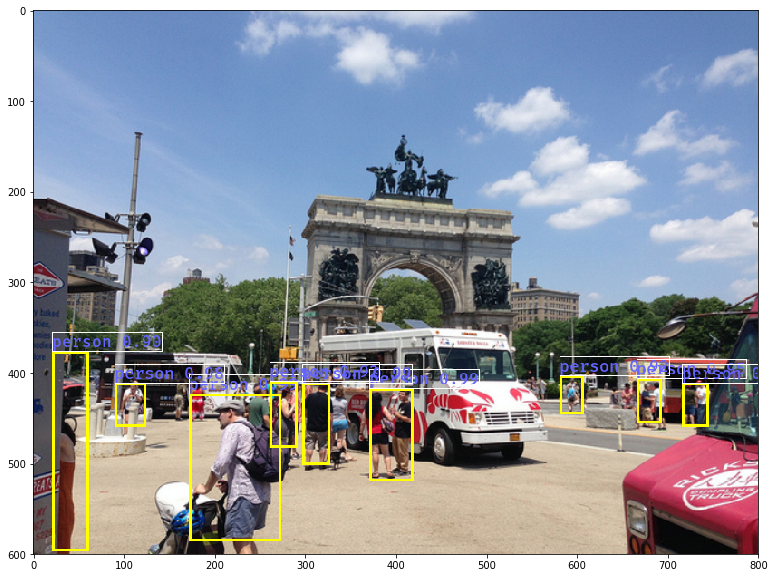

In [23]:
pred_boxes, scores, classes, rois, im_data = net.detect("./test_im/COCO_val2014_000000000133.jpgg", thr=0.9)
result_show(im_data[0], pred_boxes, classes, scores)

In [ ]:
print 1

In [ ]:
__